# COLA Emulator Tests
As the emulator is imported, a bunch of data is loaded so it might take a minute to import

In [1]:
import colaemulator1 as colaemu
import sys
sys.path.append('/home/grads/data/xiao/miniconda/envs/cocoaemu/lib/python3.7/site-packages')
import euclidemu2 as ee2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
from smt.sampling_methods import LHS
from scipy.interpolate import interp1d
from emulator_funcs import redshifts, ks, params, lims
import emulator_funcs as emu
from tensorflow import keras

2022-12-13 14:45:13.764774: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-12-13 14:45:13.764808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: amypond
2022-12-13 14:45:13.764814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: amypond
2022-12-13 14:45:13.764920: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2022-12-13 14:45:13.764941: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-12-13 14:45:13.764946: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.141.3 does not match DSO version 470.161.3 -- cannot find working devices in this configuration
2022-12-13 14:45:13.765177: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFl

In [2]:
# Matplotlib settings
axislabelfontsize='large'
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
})
axislabelfontsize='large'

In [3]:
# Generate test LHS
# Defining sampler
xlimits = np.array([lims[param] for param in params])
sampler = LHS(xlimits=xlimits, random_state=1234) # Fixing state for reproducibility
num_of_test_points = 200
test_sample = sampler(num_of_test_points)

## Timing

In [4]:
    cosmo_par={'As':2.1e-9,
               'ns':0.96,
               'Omb':0.05,
               'Omm':0.3,
               'h':0.67,
               'w0':-1,
               'wa':0,
               'mnu':0.058}

In [5]:
%time
ks_cola, boost_colaemu = colaemu.get_boost(cosmo_par)

CPU times: user 41 µs, sys: 14 µs, total: 55 µs
Wall time: 9.54 µs


In [6]:
ks_ee2, boost_ee2 = ee2.get_boost(cosmo_par, redshifts=[3])

## Testing all redshifts

In [7]:
# Testing all cosmologies in sample
boosts_ee2 = np.empty((len(test_sample), len(redshifts), len(ks_ee2)))
boosts_colaemu = np.empty((len(test_sample), len(redshifts), len(ks_ee2)))
for i, params in enumerate(test_sample):
    cosmo_par={'As':params[3]*1e-9,
               'ns':params[4],
               'Omb':params[1],
               'Omm':params[2],
               'h':params[0],
               'w0':-1,
               'wa':0,
               'mnu':0.058}
    ks_ee2, boost_ee2 = ee2.get_boost(cosmo_par, redshifts=redshifts)
    for j in range(len(redshifts)):
        boosts_ee2[i,j,:] = boost_ee2[j]
    ks_cola, boosts_colaemu[i] = colaemu.get_boost(cosmo_par, ks_ee2)

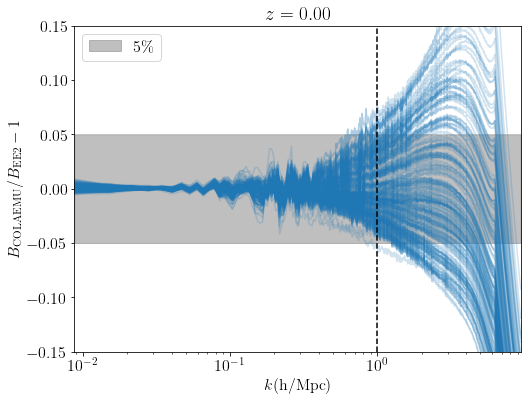

In [8]:
for j in range(1):
    for i in range(len(test_sample)):
        plt.semilogx(ks_ee2, boosts_colaemu[i,j,:]/boosts_ee2[i,j,:] - 1, color='tab:blue', alpha=0.2)
    plt.xlabel(r'$k (\mathrm{h/Mpc})$')
    plt.ylabel(r'$B_\mathrm{COLAEMU}/B_\mathrm{EE2} - 1$')
    plt.ylim([-0.15, 0.15])
    plt.xlim([ks_ee2[0], ks_ee2[-1]])
    plt.title(r'$z = {:.2f}$'.format(redshifts[j]))
    plt.fill_between(ks_ee2, -0.05, 0.05, color='gray', alpha=0.5)
    plt.axvline(1, 0, 1, color='black', linestyle='--')

    shaded_region = mpatches.Patch(color='gray', alpha=0.5, label=r'5\%')
    plt.legend(handles=[shaded_region])


    plt.savefig('COLA_EMU_1_VS_EE2_Z={:.2f}.pdf'.format(redshifts[j]))
    plt.show()

## Testing different architectures

In [33]:
# Load any NN model
emu_params = [[2, 1024], [2, 1536], [3, 1024], [4, 1024]]

nn_model_today = keras.models.load_model(f'./NN_MODELS/COLA_EMU_1_NHID=2_NEURONS=1024_z={emu.redshifts[0]:.3f}_SPLIT')
def get_boost_today(emu_params, cosmo_params, ks = emu.ks):
    '''
    Input: cosmo_params, a dictionary of cosmological parameters `As`, `ns`, `Omb`, `Omm`, `h`;
    ks, an array of scales to return
    z, an array of redshifts to return
    Output: Boost B(k, z) = P_NL / P_L for the specified cosmology on the specified grid of k and z.
    Shape: (len(z), len(ks)). Smaller redshifts come first in the array.
    Also output ks.
    Default ks and zs are the COLA outputs.
    '''

    nn_model_today = keras.models.load_model(f'./NN_MODELS/COLA_EMU_1_NHID={emu_params[0]}_NEURONS={emu_params[1]}_z={emu.redshifts[0]:.3f}')
    As = cosmo_params['As']
    ns = cosmo_params['ns']
    h  = cosmo_params['h']
    Omega_m = cosmo_params['Omm']
    Omega_b = cosmo_params['Omb']
    
    boost_in_cola_ks_zs = np.zeros((len(emu.redshifts), len(emu.ks)))
    
    params = np.array([Omega_m, Omega_b, ns, As*10**9, h])
    norm_params = emu.normalize_params(params)
    
    for i in range(len(emu.redshifts[0:1])):
        emulated_norm_pcs = nn_model_today(np.array([norm_params])) # NN outputs normalized PC components
        emulated_pcs = emu.unnormalize_array(emulated_norm_pcs, colaemu.pc_components[:,i,:]) # Rescaling PC components
        emulated_norm_log_boost = colaemu.pcas[i].inverse_transform(emulated_pcs)
        emulated_log_boost = emu.unnormalize_array(emulated_norm_log_boost, colaemu.log_boosts[:,i,:])
        boost_in_cola_ks_zs[i] = np.exp(emulated_log_boost)
    
    
    boost_in_desired_ks_zs = boost_in_cola_ks_zs
    
    return ks, boost_in_desired_ks_zs

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
EuclidEmulator2 emulates the non-li

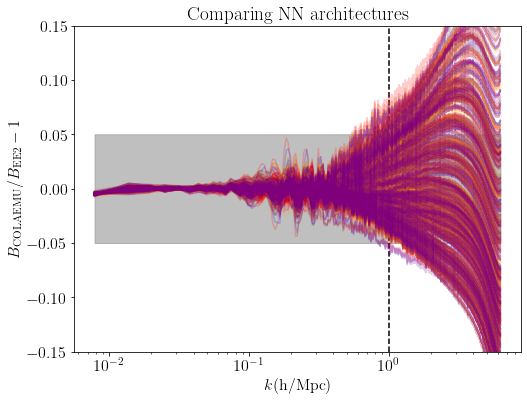

In [35]:
# Testing all cosmologies in sample
colors = ['blue', 'red', 'orange', 'purple', 'cyan']
for color, emu_param in zip(colors, emu_params):
    for i, params in enumerate(test_sample):
        cosmo_par={'As':params[3]*1e-9,
                   'ns':params[4],
                   'Omb':params[1],
                   'Omm':params[2],
                   'h':params[0],
                   'w0':-1,
                   'wa':0,
                   'mnu':0.058}
        ks_ee2, boost_ee2 = ee2.get_boost(cosmo_par, [0], emu.ks)
        ks_cola, boost_colaemu = get_boost_today(emu_param, cosmo_par)
        plt.semilogx(ks_ee2, boost_colaemu[0]/boost_ee2[0] - 1, color=color, alpha=0.2)
    plt.xlabel(r'$k (\mathrm{h/Mpc})$')
    plt.ylabel(r'$B_\mathrm{COLAEMU}/B_\mathrm{EE2} - 1$')
    plt.ylim([-0.15, 0.15])
    plt.title(f'Comparing NN architectures - Nhid={emu_param[0]}, N_neurons={emu_param[1]}')
    plt.fill_between(ks_ee2, -0.05, 0.05, color='gray', alpha=0.5)
    plt.vlines(1, -0.15, 0.15, color='black', linestyle='--')
    plt.savefig(f'COMPARING_ARCHITECTURES_{i}.pdf')

In [36]:
emu.redshifts[31]

1.526

In [31]:
# Compare with simulations
# Loading boosts from Data/
log_boosts = np.zeros((400, len(emu.redshifts), len(emu.ks)))
for i in range(400):
    log_boosts[i] = np.loadtxt(f'./Data/LogBoosts/log_boosts_{i}.txt')

In [32]:
# Load cosmologies in LHS
num_of_points = 400
sample = np.genfromtxt('./Data/lhs.txt')

In [33]:
sample[0]

array([2.41886529e-01, 5.82436493e-02, 9.72340153e-01, 1.97524136e-09,
       6.16233447e-01])

In [ ]:
for params in sample[:50]:
    cosmo_par={'As':params[3],
               'ns':params[2],
               'Omb':params[1],
               'Omm':params[0],
               'h':params[4],
               'w0':-1,
               'wa':0,
               'mnu':0.058}
    